<a href="https://colab.research.google.com/github/parasail-ai/cookbook/blob/main/vlm_get_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Started with Vision Language Model (VLM)

In this notebook, we show how to use Vision Language Models (VLMs). At Parasail, we support 100+ VLM models including Llama 3.2, LLaVA, Phi, Pixtral, Qwen-VL, Intern-VL family and more.


## Setup

Install and import dependency libraries.

In [10]:
%pip install openai datasets > /dev/null

import asyncio
import base64
import io
import time
import dataclasses

from IPython.display import Image, display
from PIL import ImageOps

import aiohttp
from datasets import load_dataset
import numpy as np
import openai

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Next, set up OpenAI API client. Note that for [serverless models](https://www.saas.parasail.io/serverless), the API key is **different** for each model. In this example, we'll use [Qwen2-VL 7B](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct) model.

In [11]:
MODEL = "cloud-qwen2-vl-7b-instruct"
API_KEY = "sk-APK_KEY_HERE"

ENDPOINT_BASE_URL = "https://litellm.gw.cloud.saas.parasail.io"
ENDPOINT_URL = ENDPOINT_BASE_URL + "/chat/completions"

## Basic usage

In this section, we show the basic usage of image inputs in the Chat Completion API.

First, download images we'll be using in the example.

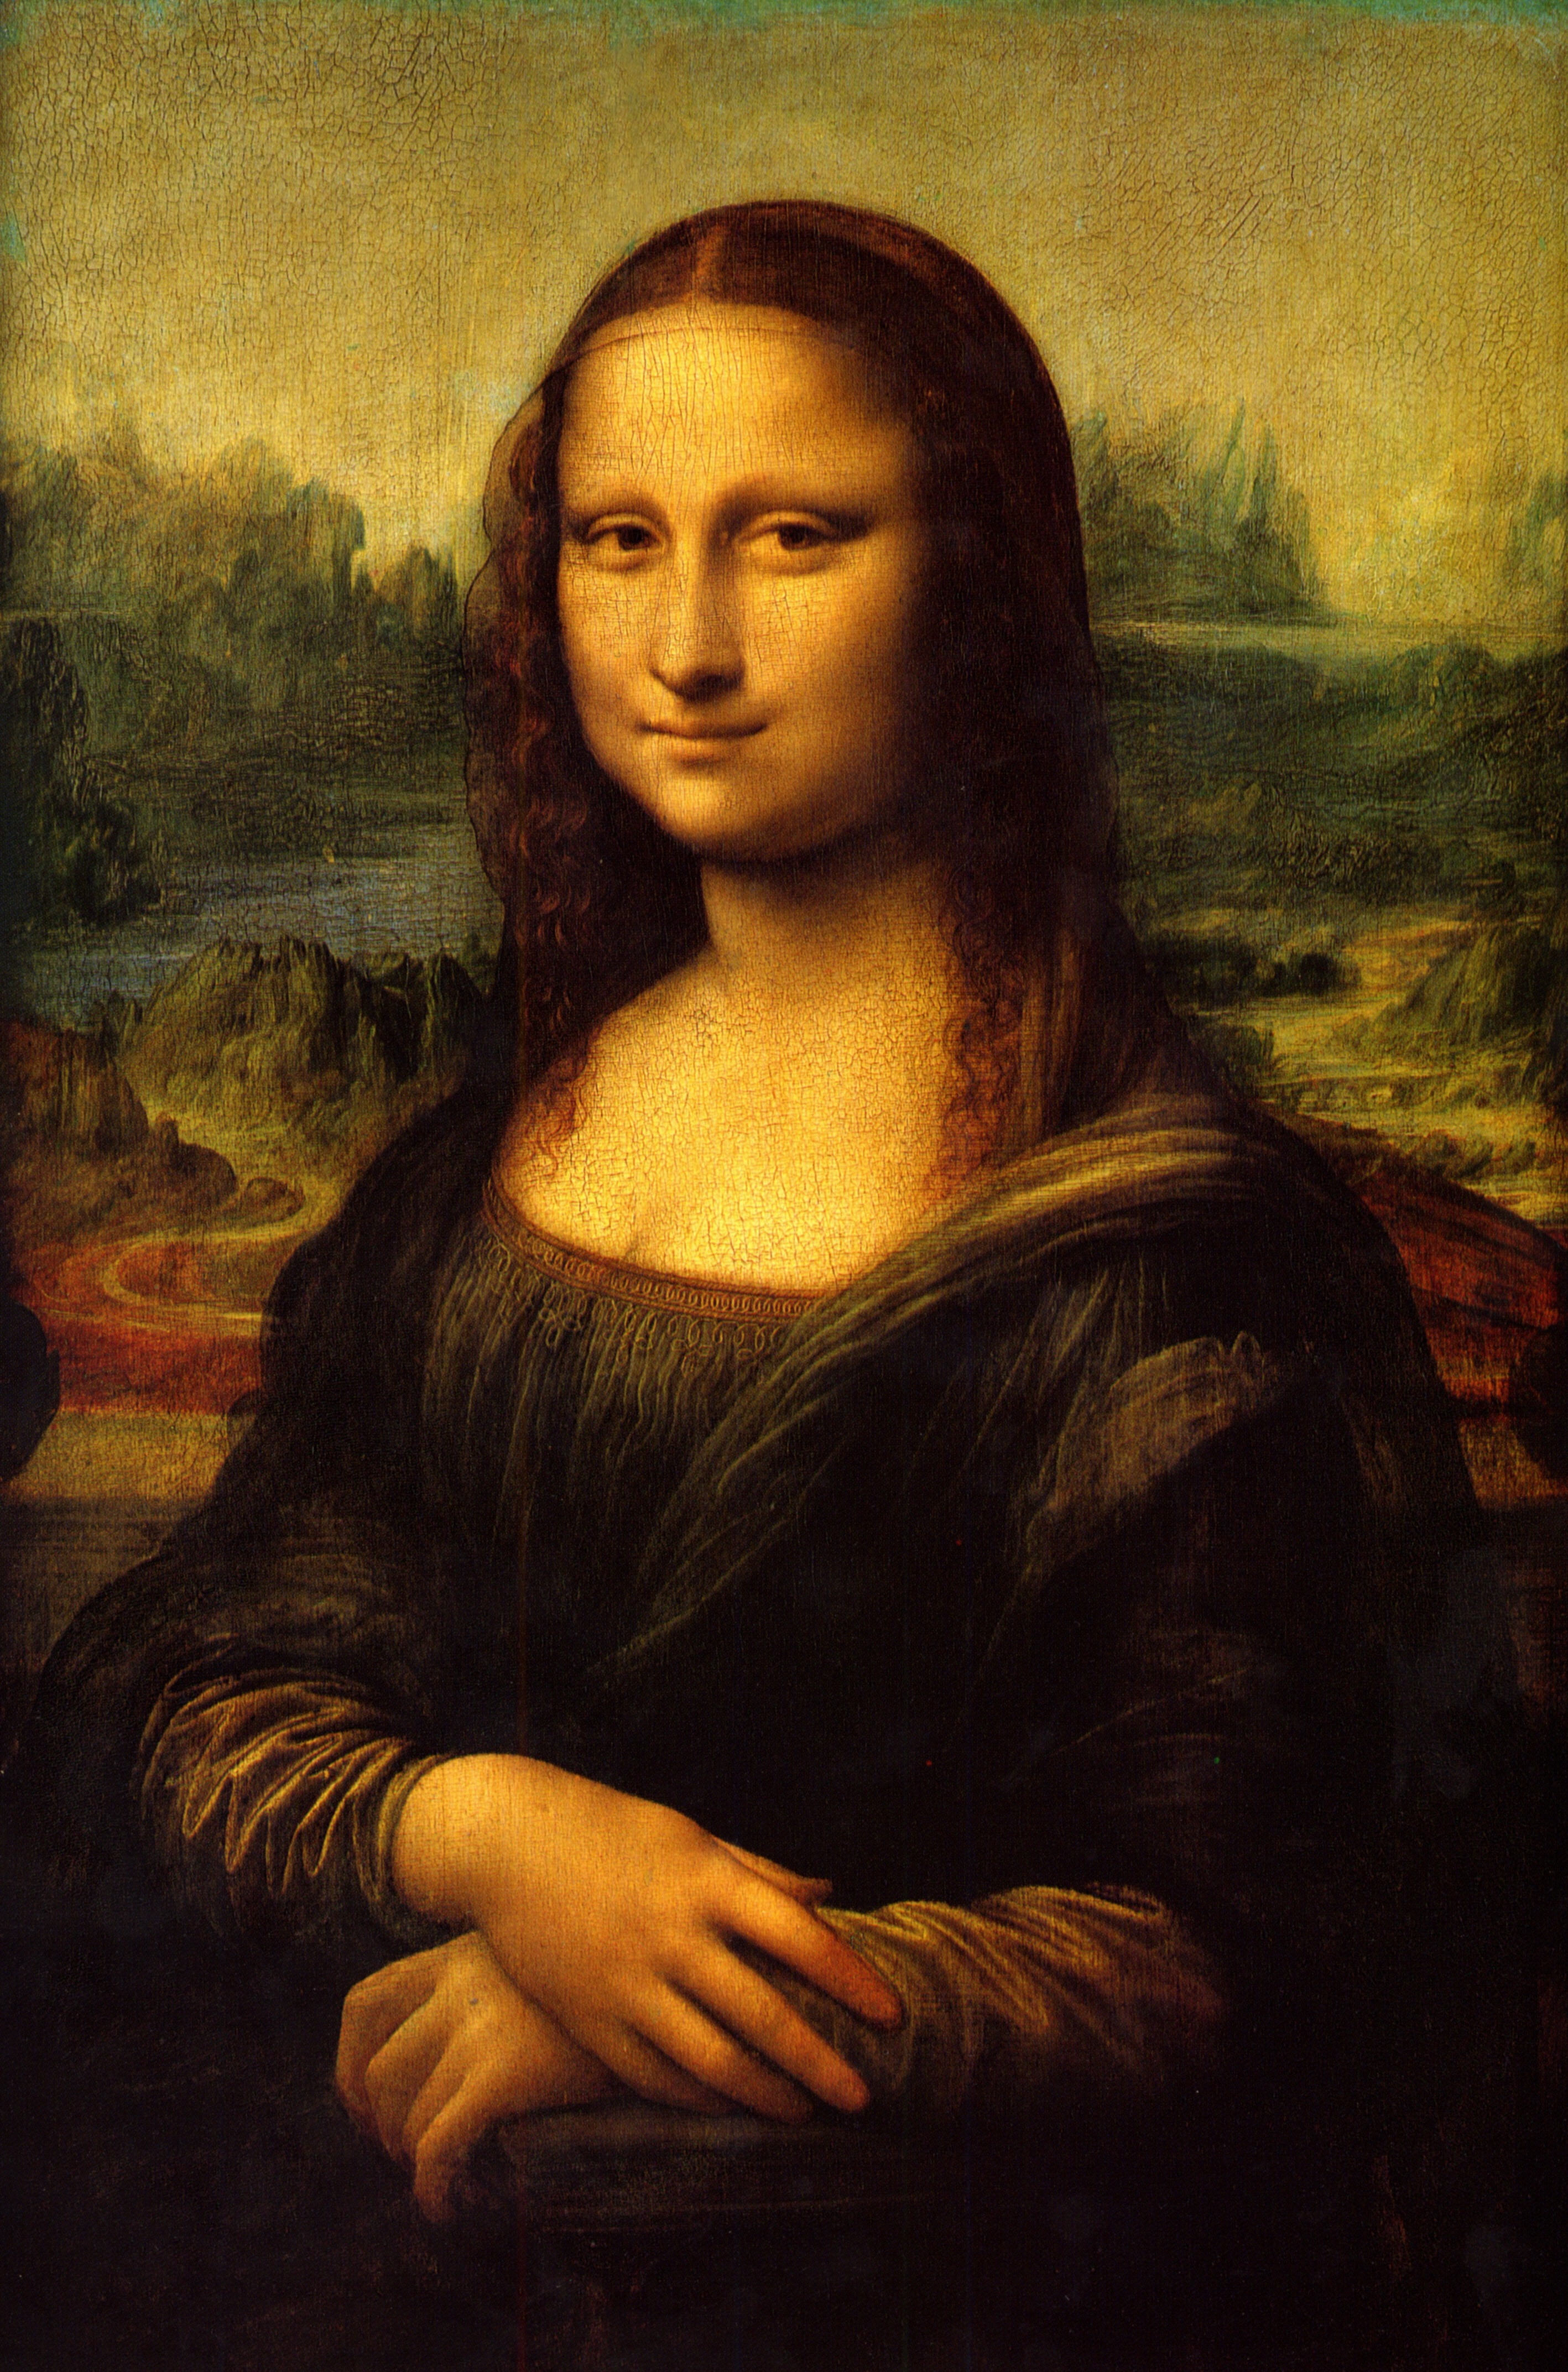

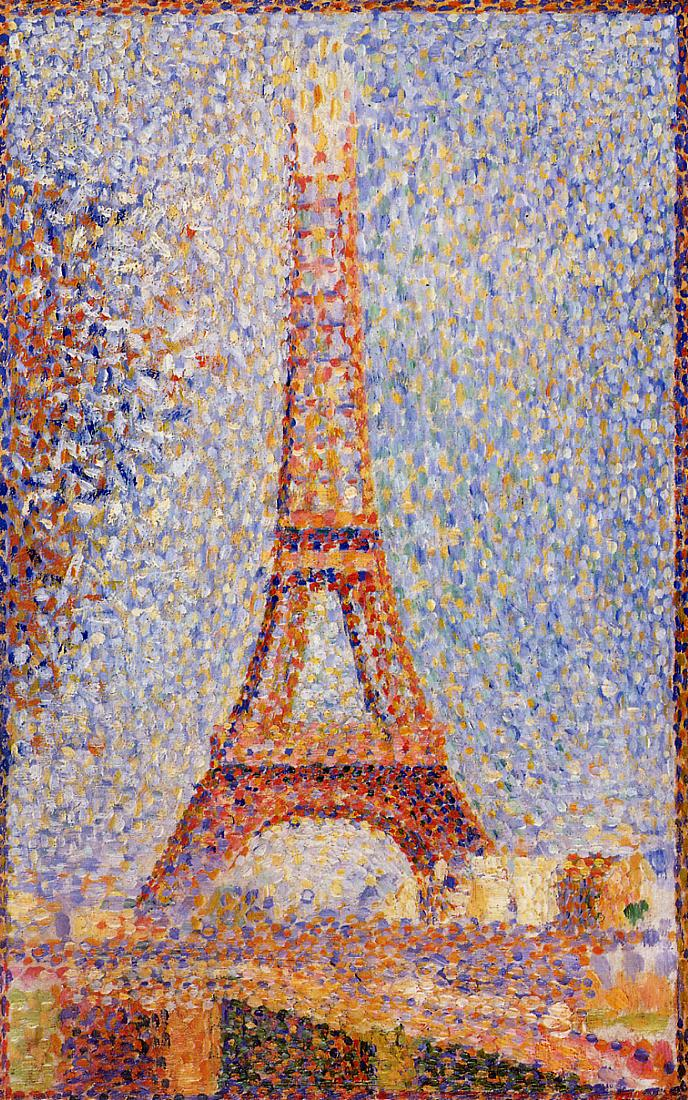

In [12]:
!wget https://upload.wikimedia.org/wikipedia/commons/6/6a/Mona_Lisa.jpg -O Mona_Lisa.jpg &> /dev/null
!wget https://upload.wikimedia.org/wikipedia/commons/8/8a/Georges_Seurat_-_Tour_Eiffel.jpg -O Tour_Eiffel.jpg &> /dev/null
display(Image("Mona_Lisa.jpg", width=300))
display(Image("Tour_Eiffel.jpg", width=300))

The API is compatible with [OpenAI's API](https://platform.openai.com/docs/guides/text-generation?text-generation-quickstart-example=image), in which the image inputs are passed in as base64 encoded strings.

In [13]:
client = openai.OpenAI(api_key=API_KEY, base_url=ENDPOINT_BASE_URL)


def to_base64_url(filename):
    with open(filename, "rb") as f:
        return "data:image/jpeg;base64," + base64.b64encode(f.read()).decode("ascii")


chat_completion = client.chat.completions.create(
    model=MODEL,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Do you know who drew the paintings?​",
                },
                {
                    "type": "image_url",
                    "image_url": {"url": to_base64_url("Mona_Lisa.jpg")},
                },
                {
                    "type": "image_url",
                    "image_url": {"url": to_base64_url("Tour_Eiffel.jpg")},
                },
            ],
        }
    ],
    max_tokens=2048,
    temperature=0,
)

chat_completion.choices[0].message.content

'The first painting is "Mona Lisa" by Leonardo da Vinci. The second painting is "The Eiffel Tower" by Georges Seurat.'

# Benchmark

In this section, we'll run a quick benchmark of the VLM API endpoint. The end-to-end latency will be affected by many factors including model size, image resolution, number of image inputs, and server load.

In [14]:
# Benchmark request rate (QPS).
REQUEST_RATE = 40

# Number of requests.
NUM_REQUESTS = 1024

# Maximum number of output tokens.
MAX_TOKENS = 1

# Input images will be resized to be fit in (IMAGE_SIZE_LIMIT, IMAGE_SIZE_LIMIT).
IMAGE_SIZE_LIMIT = 672


@dataclasses.dataclass
class Metrics:
    latency_s: float
    num_prompt_tokens: int
    num_completion_tokens: int


def encode_image(image):
    buf = io.BytesIO()
    ImageOps.contain(image.convert('RGB'), (IMAGE_SIZE_LIMIT, IMAGE_SIZE_LIMIT)).save(buf, format="JPEG")
    return f"data:image/jpeg;base64,{base64.b64encode(buf.getvalue()).decode('ascii')}"


# Use aiohttp directly for lower client-side overhead.
async def send_request(session, question, image):
    start_time = time.perf_counter()

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {API_KEY}",
    }
    data = {
        "model": MODEL,
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": question,
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": image},
                    },
                ],
            }
        ],
        "max_tokens": MAX_TOKENS,
    }

    async with session.post(url=ENDPOINT_URL, json=data, headers=headers) as resp:
        if resp.status != 200:  # retry once
            resp = await session.post(url=ENDPOINT_URL, json=data, headers=headers)
        resp = await resp.json()
        return Metrics(
            time.perf_counter() - start_time,
            resp["usage"]["prompt_tokens"],
            resp["usage"]["completion_tokens"],
        )


def print_metrics(metrics):
    print(f"----------------\nModel {MODEL}:")
    for field in dataclasses.fields(Metrics):
        values = [getattr(metric, field.name) for metric in metrics]
        print(
            f"{field.name:<25}: (mean: {np.mean(values):.2f}, "
            f"median: {np.median(values):.2f}, 95%-percentile {np.percentile(values, 95):.2f})"
        )


async def benchmark():
    async with aiohttp.ClientSession() as session:
        # Use RLAIF-V-Dataset for benchmark
        dataset = load_dataset(
            "openbmb/RLAIF-V-Dataset",
            split="train",
            data_files=["RLAIF-V-Dataset_000.parquet"],
        ).shuffle(seed=42)

        async def requests():
            total_requests = 0
            for row in dataset:
                yield (row["question"], encode_image(row["image"]))
                total_requests += 1
                if total_requests >= NUM_REQUESTS:
                    break
                await asyncio.sleep(np.random.exponential(1.0 / REQUEST_RATE))

        tasks = []
        async for question, image in requests():
            tasks.append(asyncio.create_task(send_request(session, question, image)))

        print_metrics(await asyncio.gather(*tasks))


await benchmark()

----------------
Model cloud-qwen2-vl-7b-instruct:
latency_s                : (mean: 0.74, median: 0.74, 95%-percentile 1.05)
num_prompt_tokens        : (mean: 453.15, median: 440.00, 95%-percentile 610.00)
num_completion_tokens    : (mean: 1.00, median: 1.00, 95%-percentile 1.00)
